In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the train dataset
train = pd.read_csv('../data/raw/Train.csv')
test = pd.read_csv('../data/raw/Test.csv')
# Display the first few rows of the datasets and their shape
display("Train", train.head(), train.shape, "Test", test.head(), test.shape)

'Train'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid,target
0,ID_266671248032267278,266671,Kenya,248032,267278,Type_1,8448.0,8448.0,2022-08-30,2022-09-06,7,Repeat Loan,120.85,0.014305,121.0,0
1,ID_248919228515267278,248919,Kenya,228515,267278,Type_1,25895.0,25979.0,2022-07-30,2022-08-06,7,Repeat Loan,7768.50,0.300000,7794.0,0
2,ID_308486370501251804,308486,Kenya,370501,251804,Type_7,6900.0,7142.0,2024-09-06,2024-09-13,7,Repeat Loan,1380.00,0.200000,1428.0,0
3,ID_266004285009267278,266004,Kenya,285009,267278,Type_1,8958.0,9233.0,2022-10-20,2022-10-27,7,Repeat Loan,2687.40,0.300000,2770.0,0
4,ID_253803305312267278,253803,Kenya,305312,267278,Type_1,4564.0,4728.0,2022-11-28,2022-12-05,7,Repeat Loan,1369.20,0.300000,1418.0,0


(68654, 16)

'Test'

,ID,customer_id,country_id,tbl_loan_id,lender_id,loan_type,Total_Amount,Total_Amount_to_Repay,disbursement_date,due_date,duration,New_versus_Repeat,Amount_Funded_By_Lender,Lender_portion_Funded,Lender_portion_to_be_repaid
0,ID_269404226088267278,269404,Kenya,226088,267278,Type_1,1919.0,1989.0,2022-07-27,2022-08-03,7,Repeat Loan,575.7,0.300000,597.0
1,ID_255356300042267278,255356,Kenya,300042,267278,Type_1,2138.0,2153.0,2022-11-16,2022-11-23,7,Repeat Loan,0.0,0.000000,0.0
2,ID_257026243764267278,257026,Kenya,243764,267278,Type_1,8254.0,8304.0,2022-08-24,2022-08-31,7,Repeat Loan,207.0,0.025079,208.0
3,ID_264617299409267278,264617,Kenya,299409,267278,Type_1,3379.0,3379.0,2022-11-15,2022-11-22,7,Repeat Loan,1013.7,0.300000,1014.0
4,ID_247613296713267278,247613,Kenya,296713,267278,Type_1,120.0,120.0,2022-11-10,2022-11-17,7,Repeat Loan,36.0,0.300000,36.0


(18594, 15)

In [3]:
# Check column types & missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68654 entries, 0 to 68653
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           68654 non-null  object 
 1   customer_id                  68654 non-null  int64  
 2   country_id                   68654 non-null  object 
 3   tbl_loan_id                  68654 non-null  int64  
 4   lender_id                    68654 non-null  int64  
 5   loan_type                    68654 non-null  object 
 6   Total_Amount                 68654 non-null  float64
 7   Total_Amount_to_Repay        68654 non-null  float64
 8   disbursement_date            68654 non-null  object 
 9   due_date                     68654 non-null  object 
 10  duration                     68654 non-null  int64  
 11  New_versus_Repeat            68654 non-null  object 
 12  Amount_Funded_By_Lender      68654 non-null  float64
 13  Lender_portion_F

In [4]:
# Are there missing values in the train dataset ?
print(f"There are {train.isna().sum().sum()} missing values in the data.")

There are 0 missing values in the data.


In [5]:
def plot_continuous(df, column, transform=None):
    """
    Plots visualizations for a continuous variable, showing the distribution and boxplot for both
    the original and transformed versions of the data.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The column name of the continuous variable to plot.
        transform (str, optional): Transformation to apply to the data before plotting.
                                  Accepted values are 'log' or 'sqrt'. Default is None, which means no transformation.

    This function generates:
        - A histogram with a kernel density estimate (KDE) for the original data.
        - A boxplot for the original data.
        - If a transformation is specified ('log' or 'sqrt'):
            - A histogram with a KDE for the transformed data.
            - A boxplot for the transformed data.
    """
    # Create subplots for visualizations
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))

    # Original data plots
    sns.histplot(df[column], kde=True, ax=axs[0, 0])
    axs[0, 0].set_title(f'Distribution of {column}')
    axs[0, 0].set_xlabel(column)

    sns.boxplot(y=df[column], ax=axs[1, 0])
    axs[1, 0].set_title(f'Box Plot of {column}')
    axs[1, 0].set_ylabel(column)

    # Transformations (log or square root)
    if transform == 'log':
        transformed_data = np.log1p(df[column])  # log1p handles log(0) gracefully
        transform_label = 'Log'
    elif transform == 'sqrt':
        transformed_data = np.sqrt(df[column])  # Square root transformation
        transform_label = 'Square Root'
    else:
        transformed_data = None  # No transformation if not specified

    # If transformed data exists, generate corresponding plots
    if transformed_data is not None:
        sns.histplot(transformed_data, kde=True, ax=axs[0, 1])
        axs[0, 1].set_title(f'{transform_label} Distribution of {column}')
        axs[0, 1].set_xlabel(f'{transform_label}({column})')

        sns.boxplot(y=transformed_data, ax=axs[1, 1])
        axs[1, 1].set_title(f'{transform_label} Box Plot of {column}')
        axs[1, 1].set_ylabel(f'{transform_label}({column})')
    else:
        # If no transformation, remove the second set of axes
        for ax in [axs[0, 1], axs[1, 1]]:
            ax.remove()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


def plot_categorical(df, column):
    """
    Plots visualizations for a categorical variable, including a bar plot and a pie chart.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The column name of the categorical variable to plot.

    This function generates:
        - A bar plot showing the counts of each category in the specified column.
        - A pie chart showing the relative proportions of each category.
    """
    # Create subplots for visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Bar plot showing counts of each category
    value_counts = df[column].value_counts()
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax1)
    ax1.set_title(f'Bar Plot of {column}')
    ax1.set_xlabel(column)
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Pie chart showing percentage distribution of each category
    ax2.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%')
    ax2.set_title(f'Pie Chart of {column}')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


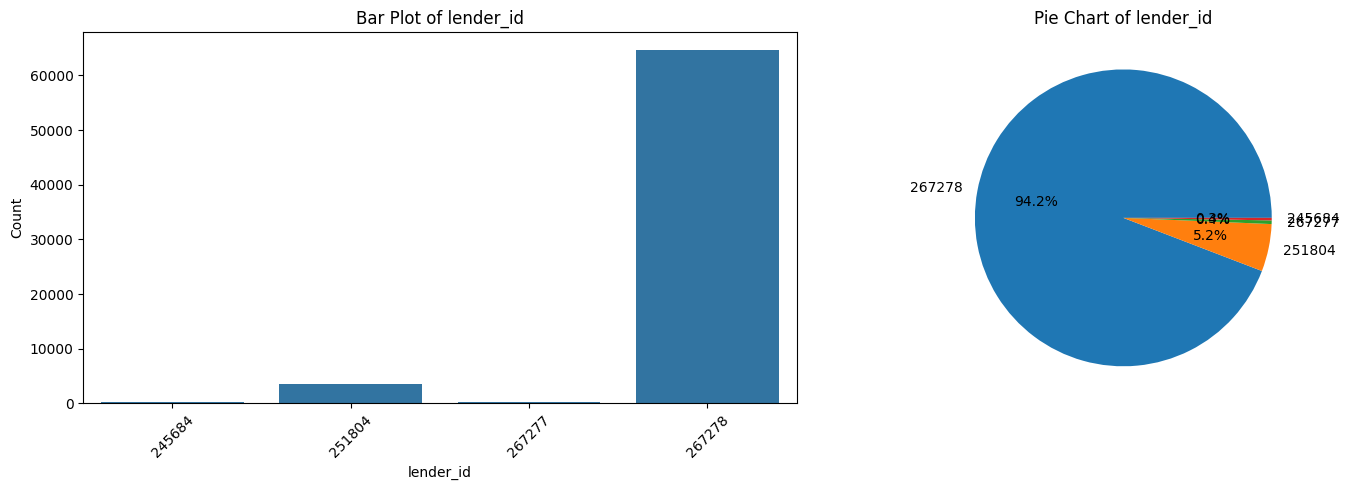

In [7]:
plot_categorical(train, 'lender_id')

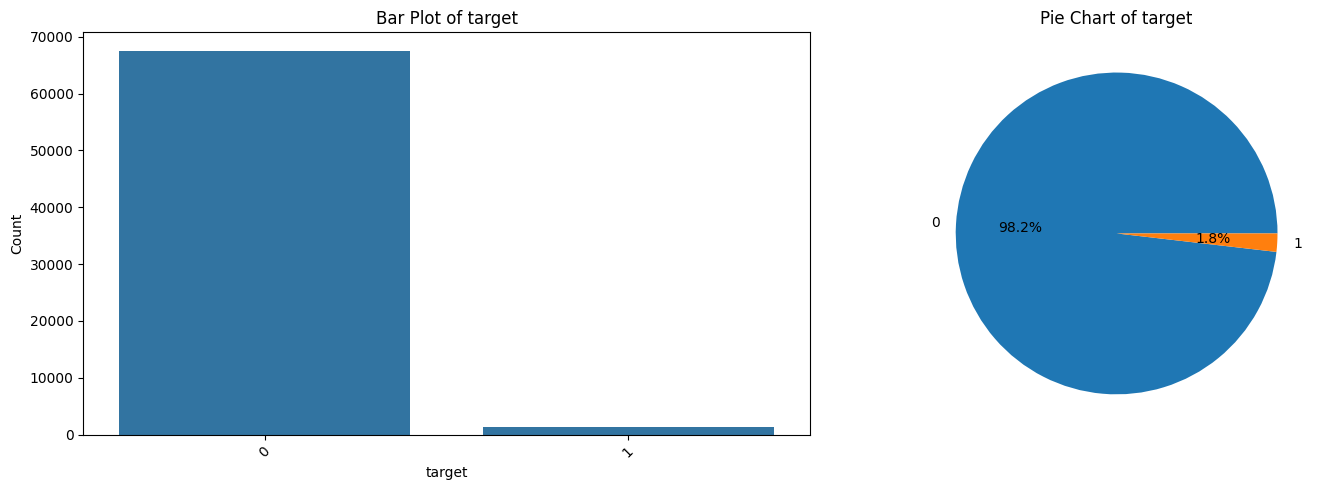

In [8]:
plot_categorical(train, 'target')

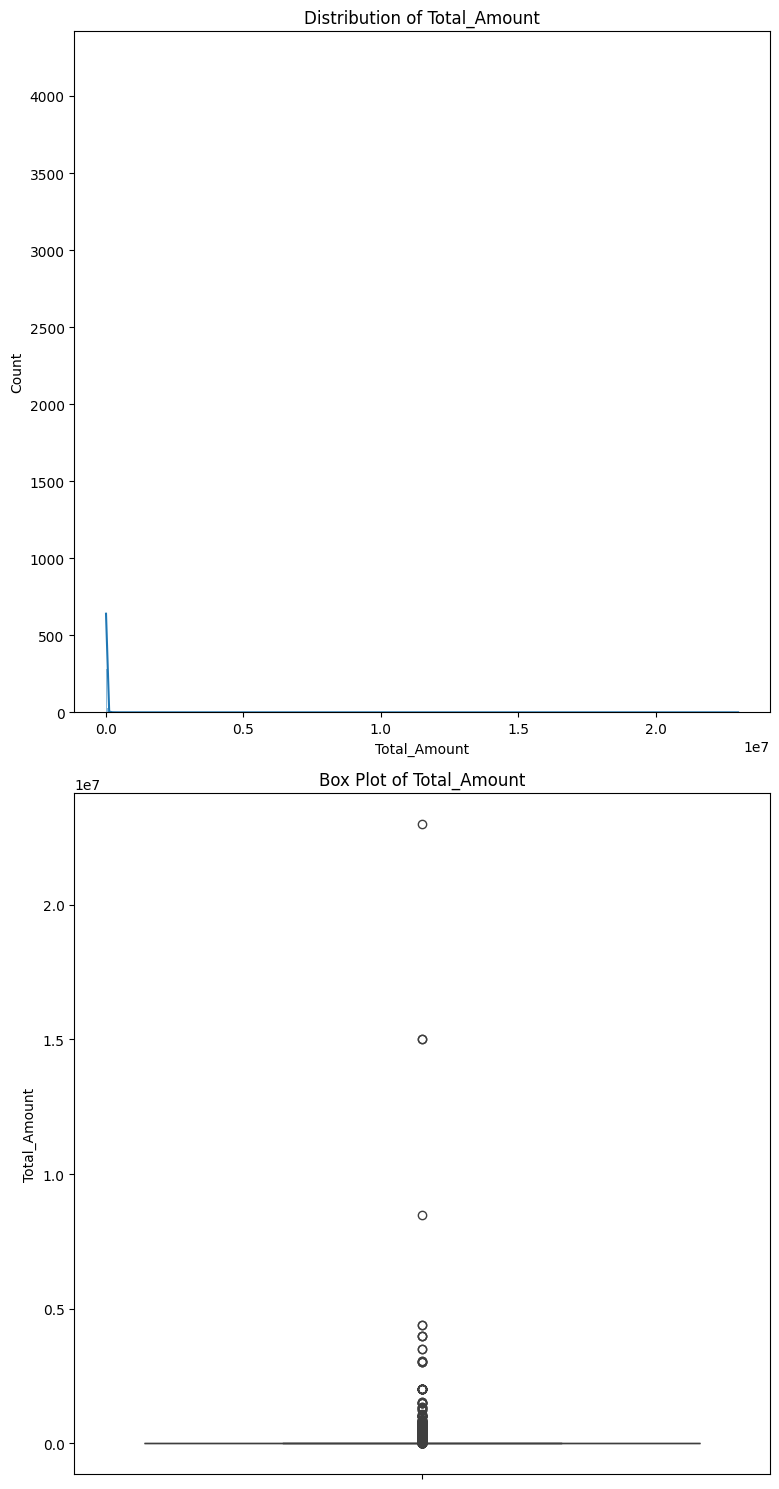

In [9]:
plot_continuous(train, 'Total_Amount')

In [10]:
data = pd.concat([train, test]).reset_index(drop=True)

# Convert the datetime columns appropriately
date_cols = ['disbursement_date', 'due_date']
for col in date_cols:
    data[col] = pd.to_datetime(data[col])
    # Extract month, day, and year from the date columns
    data[col+'_month'] = data[col].dt.month
    data[col+'_day'] = data[col].dt.day
    data[col+'_year'] = data[col].dt.year

# Select all categorical columns from the dataset and label encode them or one hot encode
cat_cols = data.select_dtypes(include='object').columns
num_cols = [col for col in data.select_dtypes(include='number').columns if col not in ['target']]
print(f"The categorical columns are: {cat_cols}.")
print("-"* 100)
print(f"The numerical columns are: {num_cols}")
print("-"* 100)
# we are going to one  hot encode the loan type
data = pd.get_dummies(data, columns=['loan_type'], prefix='loan_type', drop_first=False)
# Convert all the columns with prefix loan_type_ to 0/1 instead of False/True
loan_type_cols = [col for col in data.columns if col.startswith('loan_type_')]
data[loan_type_cols] = data[loan_type_cols].astype(int)

# Label-encoding for the other remaining categorical columns
le = LabelEncoder()
for col in [col for col in cat_cols if col not in ['loan_type', 'ID']]:
    data[col] = le.fit_transform(data[col])


# deal with numerical columns: we saw loan amount is  highly right skewed for this we can log transform it
data['Total_Amount'] = np.log1p(data['Total_Amount']) # study other numerical columns and see if they are skewed as well

# Splitting the data back into train and test
train_df = data[data['ID'].isin(train['ID'].unique())]

test_df = data[data['ID'].isin(test['ID'].unique())]

# we are also going to drop the country id as we saw we have only one country in train
features_for_modelling = [col for col in train_df.columns if col not in date_cols + ['ID', 'target', 'country_id']]

# Check if the new datasets have the same rows as train and test datasets
print(f"The shape of train_df is: {train_df.shape}")
print(f"The shape of test_df is: {test_df.shape}")
print(f"The shape of train is: {train.shape}")
print(f"The shape of test is: {test.shape}")
print(f"The features for modelling are:\n{features_for_modelling}")


The categorical columns are: Index(['ID', 'country_id', 'loan_type', 'New_versus_Repeat'], dtype='object').
----------------------------------------------------------------------------------------------------
The numerical columns are: ['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_portion_to_be_repaid', 'disbursement_date_month', 'disbursement_date_day', 'disbursement_date_year', 'due_date_month', 'due_date_day', 'due_date_year']
----------------------------------------------------------------------------------------------------
The shape of train_df is: (68654, 45)
The shape of test_df is: (18594, 45)
The shape of train is: (68654, 16)
The shape of test is: (18594, 15)
The features for modelling are:
['customer_id', 'tbl_loan_id', 'lender_id', 'Total_Amount', 'Total_Amount_to_Repay', 'duration', 'New_versus_Repeat', 'Amount_Funded_By_Lender', 'Lender_portion_Funded', 'Lender_

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_df[features_for_modelling], train['target'], stratify=train['target'], shuffle=True, random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(51490, 40) (17164, 40) (51490,) (17164,)


F1 Score: 0.3871
ROC AUC Score: 0.9656

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     16849
           1       0.89      0.25      0.39       315

    accuracy                           0.99     17164
   macro avg       0.94      0.62      0.69     17164
weighted avg       0.98      0.99      0.98     17164



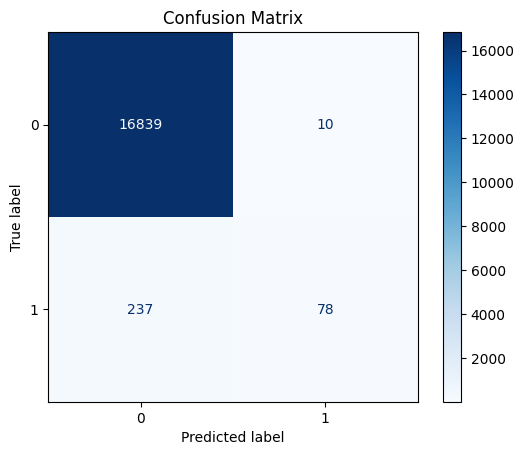

In [16]:

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Random Forest Classifier
clf = RandomForestClassifier(
    n_estimators=100,        # Number of trees in the forest
    random_state=42,         # For reproducibility
    class_weight="balanced"  # Handle class imbalance
)
clf.fit(X_train_scaled, y_train)

# Predictions
y_pred = clf.predict(X_valid_scaled)
y_pred_proba = clf.predict_proba(X_valid_scaled)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# Confusion Matrix
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(
    y_valid,
    y_pred,
    display_labels=clf.classes_,
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()


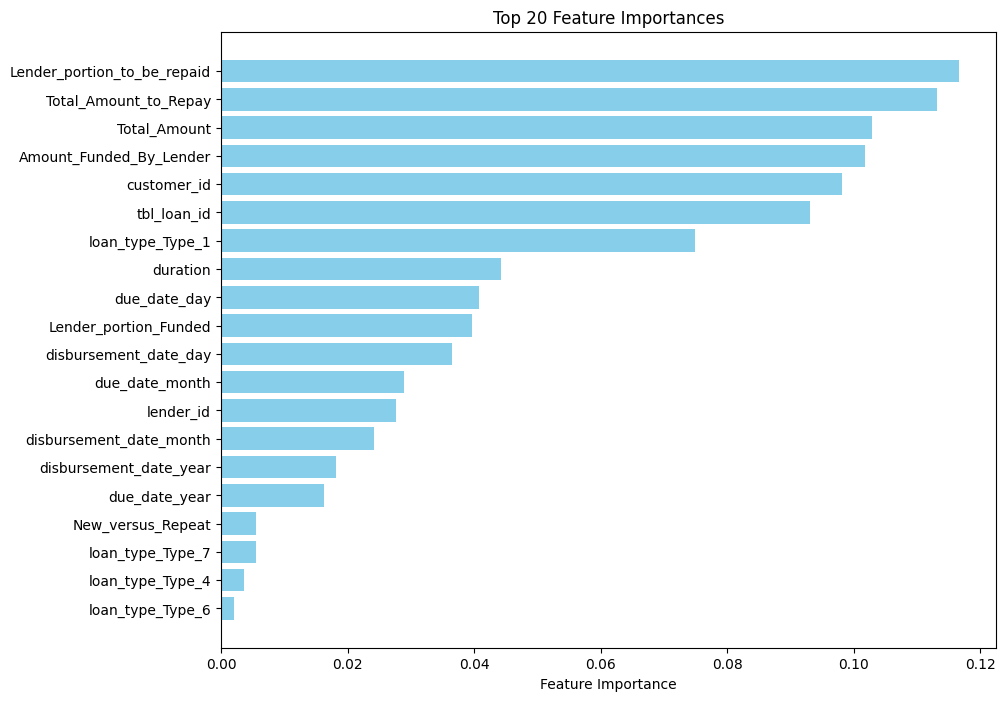

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the feature importances from the RandomForestClassifier
feature_importances = clf.feature_importances_

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': features_for_modelling,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.show()


In [14]:
# Make predictions on the test dataset
test_predictions = clf.predict(test_df[features_for_modelling])
test_predictions_proba = clf.predict_proba(test_df[features_for_modelling])[:, 1]

# Save the predictions to a CSV file

test_df['target'] = test_predictions
sub =  test_df[['ID', 'target']]
sub.head()


,ID,target
68654,ID_269404226088267278,0
68655,ID_255356300042267278,0
68656,ID_257026243764267278,0
68657,ID_264617299409267278,0
68658,ID_247613296713267278,0


The confusion matrix evaluates the performance of the classification model:

### **Matrix Breakdown**
- **True Negatives (TN)**: 16,839  
  These are correctly predicted negative cases (true class = 0, predicted class = 0).  
  Example: Cases where the model correctly identified loans as **not defaulting**.

- **False Positives (FP)**: 10  
  These are incorrectly predicted positive cases (true class = 0, predicted class = 1).  
  Example: Cases where the model incorrectly predicted loans as **defaulting**, but they did not.

- **False Negatives (FN)**: 237  
  These are incorrectly predicted negative cases (true class = 1, predicted class = 0).  
  Example: Cases where the model failed to predict loans as **defaulting**, but they actually defaulted.

- **True Positives (TP)**: 78  
  These are correctly predicted positive cases (true class = 1, predicted class = 1).  
  Example: Cases where the model correctly identified loans as **defaulting**.

---

### **Key Metrics**
1. **Accuracy**: Overall percentage of correct predictions.  
   \[
   \text{Accuracy} = \frac{\text{TP + TN}}{\text{Total}} = \frac{16839 + 78}{16839 + 10 + 237 + 78} \approx 98.5\%
   \]

2. **Precision**: Out of all predicted positives, how many were actually positive?  
   \[
   \text{Precision} = \frac{\text{TP}}{\text{TP + FP}} = \frac{78}{78 + 10} \approx 88.6\%
   \]

3. **Recall (Sensitivity)**: Out of all actual positives, how many were correctly predicted?  
   \[
   \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} = \frac{78}{78 + 237} \approx 24.8\%
   \]

4. **F1-Score**: Harmonic mean of Precision and Recall.  
   \[
   \text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision + Recall}} \approx 38.4\%
   \]

---

### **Model Insights**
- **Strengths**:
  - High **accuracy** (98.5%), indicating that the model performs well overall due to the dominance of the majority class (non-defaults).
  - High **precision** (88.6%), meaning most loans predicted as defaulting are correct.

- **Weaknesses**:
  - Low **recall** (24.8%), meaning the model struggles to identify actual loan defaults, missing many true cases.

---

### **Recommendation**
- The imbalance between the classes (non-defaults vs. defaults) likely affects performance.  
- Consider addressing class imbalance with strategies like:
  - **Resampling**: Oversampling the minority class (e.g., SMOTE) or undersampling the majority class.
  - **Class weights**: Already included (`class_weight="balanced"`), but further tuning may help.
  - **Alternative models**: Try models more robust to class imbalance, such as Gradient Boosting.



In [24]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib
from datetime import datetime
# Define preprocessing steps
preprocessing_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values
    ('scaler', StandardScaler())                 # Scale the features
])

# Define the model
model = RandomForestClassifier(random_state=42)

# Combine preprocessing and model into a single pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing_pipeline),
    ('classifier', model)
])

# Fit the combined pipeline on your data (assuming `raw_data` and `labels` exist)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# Save the full pipeline to a file
joblib.dump(full_pipeline, f'../pipelines/pipeline_{timestamp}.pkl')


['../pipelines/pipeline_20241213_162715.pkl']

In [19]:
import joblib
from datetime import datetime

# Generate a timestamp in a readable format
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the model with the timestamp in the file name
model_filename = f'../models/classifier_{timestamp}.pkl'
joblib.dump(clf, model_filename)
print(f"Model saved as {model_filename}")

# Load the model later (example with a hardcoded file name or dynamically listing available models)
loaded_model = joblib.load(model_filename)
print("Model loaded successfully")


Model saved as ../models/classifier_20241213_161808.pkl
Model loaded successfully
